In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Pyfolio as pyf
from Pyfolio import Implementation
from Pyfolio import OptimPort
%load_ext autoreload    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df = pd.read_excel('data.xlsx',sheet_name = 'fx',index_col = 0)
surp_idx = pd.read_excel('data.xlsx',sheet_name = 'surprize_index',index_col = 0)
short_yld = pd.read_excel('data.xlsx',sheet_name = 'shortyield',index_col = 0)
long_yld = pd.read_excel('data.xlsx',sheet_name = 'longyield',index_col = 0)
inf_idx = pd.read_excel('data.xlsx',sheet_name = 'inflation',index_col = 0)

inf_idx.drop('USDTRY',axis = 1,inplace = True)

In [10]:
assets = ['USDCHF','USDJPY','USDEUR','USDGBP','USDNOK','USDAUD','USDNZD','USDCAD','USDZAR','USDBRL','USDMXN']
df.columns = assets
## Clean data such that USD is the denominator
for col in ['USDEUR', 'USDGBP', 'USDNZD', 'USDAUD']:
    df [col] =1/df[col]
df.columns,surp_idx.columns,short_yld.columns,long_yld.columns,inf_idx.columns = assets,assets,assets,assets,assets
start_dt = '2010-01-01'
df = df[start_dt:]
surp_idx = surp_idx[start_dt:]
short_yld = short_yld[start_dt:]
long_yld = long_yld[start_dt:]
inf_idx = inf_idx[start_dt:]

#yld = yld.reindex_like(df).fillna(method = 'ffill')
#surp_idx = surp_idx.reindex_like(df).fillna(method = 'ffill')
#short_yld = short_yld.reindex_like(df).fillna(method = 'ffill')
#long_yld = long_yld.reindex_like(df).fillna(method = 'ffill')
#inf_idx = inf_idx.reindex_like(df).fillna(method = 'ffill')

### Clean Yield Differentials


In [11]:
yld = short_yld-long_yld
yld = (yld - yld.mean())/yld.std()
yld_1m_chg = yld.diff(30).shift()
yld_1m_chg

,USDCHF,USDJPY,USDEUR,USDGBP,USDNOK,USDAUD,USDNZD,USDCAD,USDZAR,USDBRL,USDMXN
Date,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,0.204237,-0.126790,-0.013522,0.034740,-0.154975,0.669700,0.066755,-0.029033,0.013618,0.168622,-0.041026
2024-06-04,0.233589,-0.170550,-0.004454,0.069296,-0.129906,0.752759,0.148202,0.075169,0.064856,0.082630,-0.138532
2024-06-05,0.219160,0.022216,0.067374,0.128035,-0.079930,0.804425,0.205215,0.132705,0.123867,0.205854,-0.146760


### Clean Inflation Data
Inflation Data is typically released 1 month late but in bbg they put it as as though it was released on time

In [12]:
inf_idx = (inf_idx-inf_idx.mean())/inf_idx.std()
inf_idx = inf_idx.shift()
inf_idx['USDNZD'] = [0]*inf_idx.shape[0]
inf_idx['USDCAD'] = [0]*inf_idx.shape[0]

### Clean Surprize Index

In [13]:
surp_idx = (surp_idx-surp_idx.mean())/surp_idx.std()
surp_idx = surp_idx.shift().fillna(0)
surp_idx

,USDCHF,USDJPY,USDEUR,USDGBP,USDNOK,USDAUD,USDNZD,USDCAD,USDZAR,USDBRL,USDMXN
Date,,,,,,,,,,,
2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,0.000000,0.191650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-06,0.000000,-0.013456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-07,0.000000,-0.348735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-08,0.000000,-0.227859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,-0.246463,-0.471798,-1.238763,-0.008143,-1.290251,-0.879338,-0.731901,-0.516613,-0.516613,-0.516613,-0.516613
2024-06-03,-0.246463,-0.461406,-0.821906,-0.008143,-0.797582,-0.879338,-0.699351,-0.478447,-0.478447,-0.478447,-0.478447
2024-06-04,0.218589,-0.471798,-0.821906,-0.008143,-0.797582,-0.879338,-0.699351,-0.685635,-0.685635,-0.685635,-0.685635


### Standardize Data

In [14]:
# Reindex like FX data
surp_idx = surp_idx.reindex_like(df).fillna(method = 'ffill').fillna(0)
inf_idx= inf_idx.reindex_like(df).fillna(method = 'ffill').fillna(0)
yld_1m_chg = yld_1m_chg.reindex_like(df).fillna(method = 'ffill').fillna(0)




C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\1788148055.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  surp_idx = surp_idx.reindex_like(df).fillna(method = 'ffill').fillna(0)
C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\1788148055.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inf_idx= inf_idx.reindex_like(df).fillna(method = 'ffill').fillna(0)
C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\1788148055.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yld_1m_chg = yld_1m_chg.reindex_like(df).fillna(method = 'ffill').fillna(0)


### Obtain forward 1-month returns of FX

In [15]:
## Get daily returns
df_chg = df.fillna(method = 'ffill').pct_change().fillna(0)

### Get 1-month forward returns
w = 20
df_1m_chg = df.fillna(method = 'ffill').pct_change(w).fillna(0)

C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\2509262536.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_chg = df.fillna(method = 'ffill').pct_change().fillna(0)
C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\2509262536.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_1m_chg = df.fillna(method = 'ffill').pct_change(w).fillna(0)


### Reindex data like fx file

In [16]:
yld_1m_chg = yld_1m_chg.reindex_like(df).fillna(method = 'ffill')
surp_idx = surp_idx.reindex_like(df).fillna(method = 'ffill')
inf_idx = inf_idx.reindex_like(df).fillna(method = 'ffill')

C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\719079070.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yld_1m_chg = yld_1m_chg.reindex_like(df).fillna(method = 'ffill')
C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\719079070.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  surp_idx = surp_idx.reindex_like(df).fillna(method = 'ffill')
C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\719079070.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inf_idx = inf_idx.reindex_like(df).fillna(method = 'ffill')


## Perform Rolling OLS with forward 1 month returns 


In [17]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm 
def rollingOLScoef(y,x,wdw):
    x = sm. add_constant(x,prepend = False)
    model = RollingOLS(y,x,window = wdw, min_nobs = 2) .fit()
    model = model.params
    model.columns = ['coef_', 'const'] 
    return model. coef_
def rollingOLSconst (x,y, wdw):
    x = sm. add_constant(x, prepend - False)
    model = RollingOLS(y,x,window = wdw,min_nobs = 2).fit()
    model = model.params
    model.columns = ['coef_', 'const'] 
    return model.const

In [18]:
#Use rolling 1-month returns to predict forward 1-month returns
wdw = 20
ret_pred = pd.DataFrame()
for a in df.columns:
    x= pd.concat([surp_idx[[a]],yld_1m_chg[[a]],inf_idx[[a]]],axis=1)
    x= sm.add_constant(x,prepend = False)
    y = df_1m_chg[[a]]
    model = RollingOLS(y,x,window = wdw, min_nobs = 4).fit()
    model = model.params
    model.columns = ['surp_idx', 'yld_1m_chg', 'inf_idx', "const"]
    pred = model.surp_idx*surp_idx[a]+ model.yld_1m_chg *yld_1m_chg[a] + model.inf_idx*inf_idx[a]+model.const
    pred = pd.DataFrame(pred, columns = [a])
    ret_pred=pd.concat([ret_pred,pred],axis = 1)
ret_pred = ret_pred.fillna(method = 'ffill').fillna(0)

C:\Users\kmavy\AppData\Local\Temp\ipykernel_17428\1475346973.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ret_pred = ret_pred.fillna(method = 'ffill').fillna(0)


## Convert Returns prediction into position vector using convex optimization. Optimize for maximum Sharpe ratio

In [20]:
WTS = []
for i in range(len(ret_pred)):
    er = ret_pred.iloc[i]
    cov = df_chg.iloc[:i].cov()
    temp_ret = df_chg.iloc[:i]
    opt = OptimPort(raw_rets=temp_ret, er = er)
    wts = opt.get_msr_wts(exposure_constraint=0)
    WTS.append(wts)


c:\Users\kmavy\anaconda3\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\kmavy\anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\kmavy\anaconda3\lib\site-packages\pandas\core\frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\kmavy\anaconda3\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\kmavy\anaconda3\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\kmavy\anaconda3\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\kmavy\anaconda3\lib\site-packages\numpy\core\_methods.py:121: Runtim

In [21]:
weights = pd.DataFrame(WTS,index = ret_pred.index, columns = ret_pred.columns)

### Make portfolio dollar neutral and reduce rebalance noise

<Axes: xlabel='Date'>

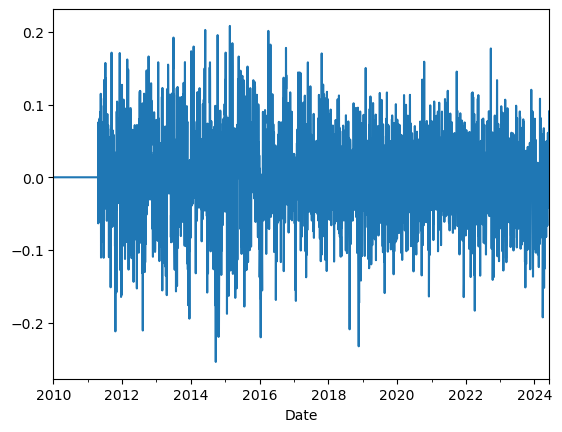

In [22]:
imp = Implementation(weights)

## Rebalance only if position vector changes by 5 percent or more
weights_clean = imp.adjust_rebalance(threshold = 0.05)
weights_clean.sum(axis=1).plot()

<Axes: xlabel='Date'>

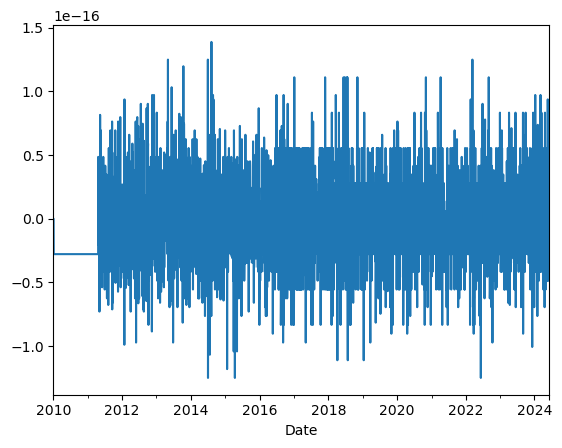

In [23]:
def subtract_series(df):
    return df -weights.mean(axis = 1)
weights_clean = weights.apply(lambda x: subtract_series(x))
def constraint_abs_w(df):
    return df/abs(weights_clean).sum(axis = 1)
weights_clean = weights_clean.apply(lambda x: constraint_abs_w(x))

#Check that portfolio is dollar neutral, sum of weights sum to as close to zero as possible
weights_clean.sum(axis=1).plot()

<Axes: xlabel='Date'>

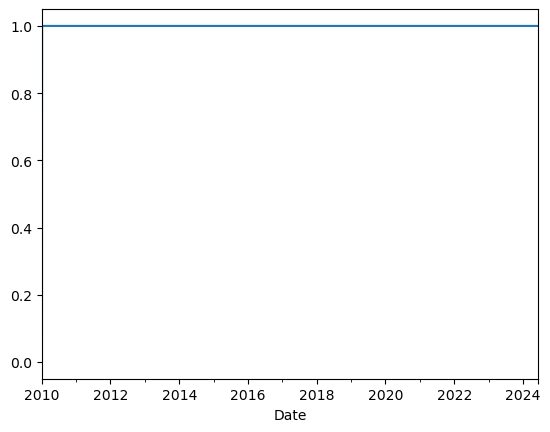

In [24]:
# Check that GMV is unlevered (Sums to 1)
abs(weights_clean).sum(axis=1).plot()

### Weight Vector

<Axes: xlabel='Date'>

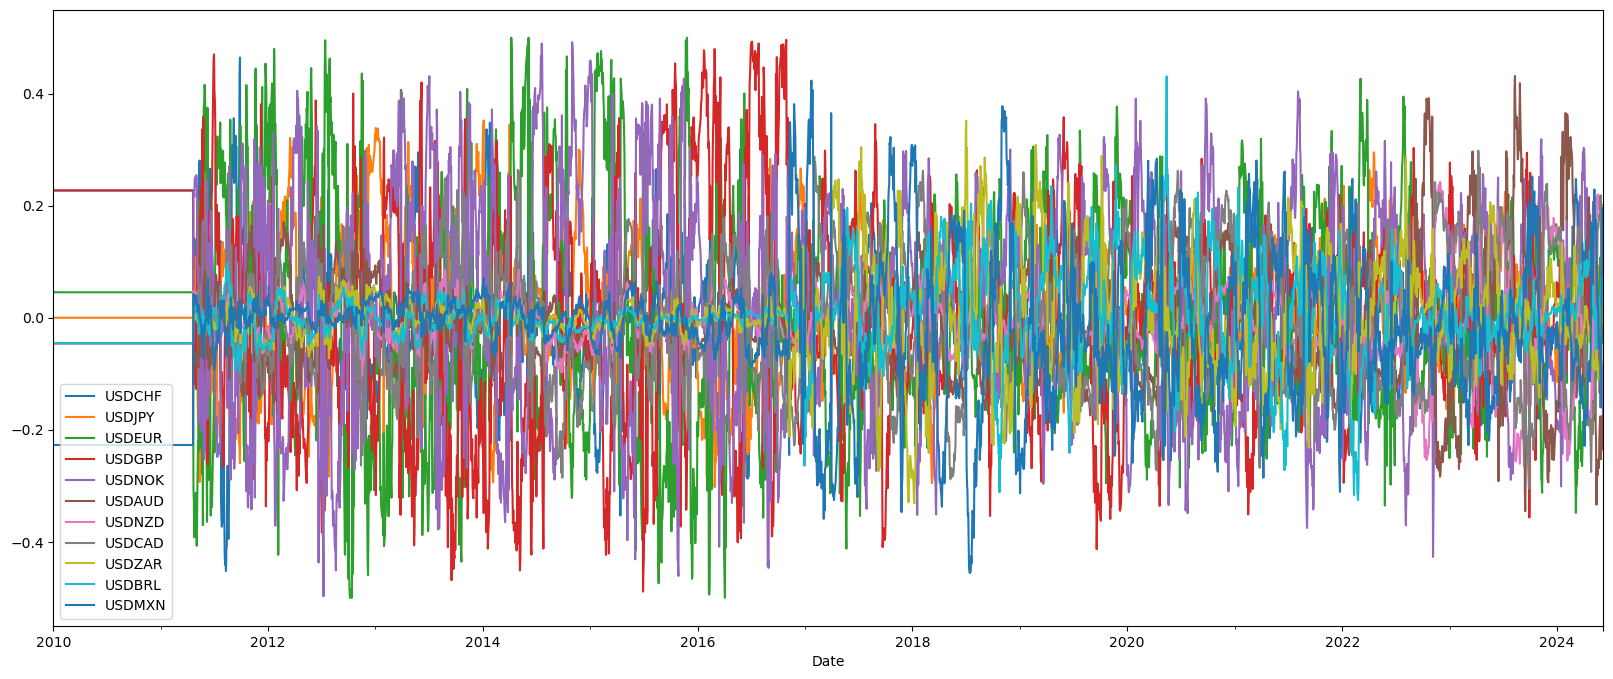

In [25]:
weights_clean.plot(figsize = (20,8))

In [26]:
# save to excel
trade_log=weights_clean
trade_log.fillna(0).diff().to_excel('fx_port_construction_trade_log.xlsx')

## Add in transaction costs

In [27]:
bidask = 0.0002
costs = abs(weights_clean.diff())* bidask 

## Plot Costs

<Axes: title={'center': 'Cumulative Transaction Costs by FX Pair (Percent)'}, xlabel='Date'>

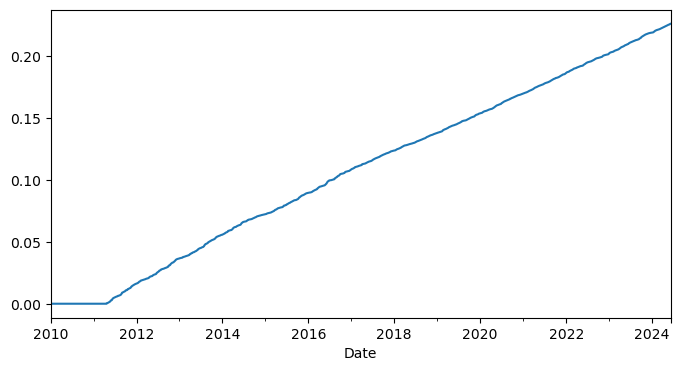

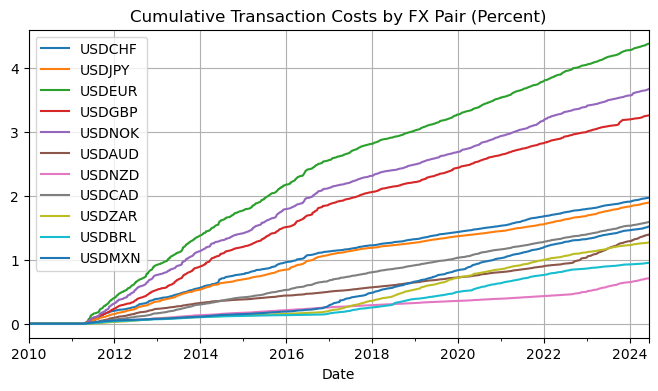

In [44]:
costs.sum(axis = 1).cumsum().plot(figsize = (8,4))
(100*costs).cumsum().plot(title = 'Cumulative Transaction Costs by FX Pair (Percent)',figsize = (8,4),grid = True)

In [29]:
costs.fillna(0).to_excel('fx_port_construction_costs.xlsx')

In [30]:
bt = weights_clean*df_chg - costs

## Generate Backtested Returns

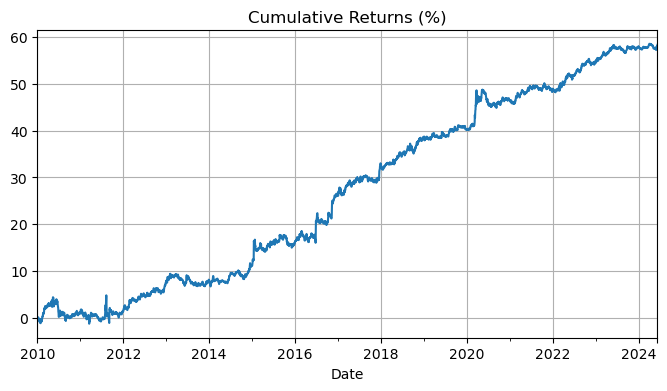

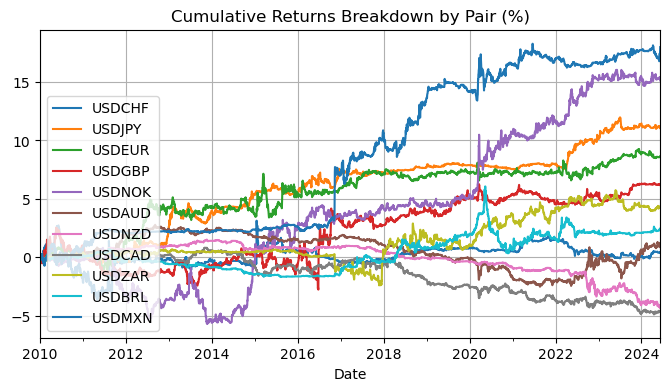

In [35]:
(100*bt).sum(axis=1).cumsum().plot(title = 'Cumulative Returns (%)',figsize = (8,4),grid = True)
(100*bt).cumsum().plot(figsize = (8,4),title = 'Cumulative Returns Breakdown by Pair (%)',grid = True)
plt.legend(loc = 'lower left')

In [36]:
bt.to_excel('fx_port_construction_returns.xlsx')

In [37]:
def get_sharpe_ratio(data):
    rets = data.mean()
    std = data.std()
    return (data.mean()*250**0.5)/data.std()
def get_max_drawdown(data):
    high_water = (1+data).cumprod().expanding().max()
    rets = (1+data).cumprod()
    dd = high_water/rets -1
    dd = -max(dd)
    return dd

In [38]:
#### Perform Simple Analytics - Max Drawdown
perf = pd.DataFrame(bt.sum(axis=1),columns = ['backtest'])
round(pd.pivot_table(perf,aggfunc = get_max_drawdown,columns =perf.index.year),3)


Date,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
backtest,-0.053,-0.061,-0.012,-0.027,-0.019,-0.028,-0.026,-0.017,-0.022,-0.011,-0.04,-0.019,-0.014,-0.017,-0.013


In [42]:
#### Perform Simple Analytics - Sharpe Ratio
perf = pd.DataFrame(bt.sum(axis=1),columns = ['backtest'])
round(pd.pivot_table(perf,aggfunc = get_sharpe_ratio,columns =perf.index.year),3)


Date,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
backtest,0.187,0.102,2.228,0.028,1.146,0.896,1.651,1.666,1.729,0.687,1.208,0.88,1.92,1.418,0.385
